# Component 2
The goal of this exercise is to develop a Convolutional Neural Network (CNN) model capable
of classifying different types of vehicle damages based on images. The categories of vehicle
damage include crack, scratch, tire flat, dent, glass shatter and lamp broken. The model should
be trained to automatically assess the legitimacy of vehicle damage claims, which is essential
for insurance verification. In this exercise, you will build a CNN to accurately identify the
damage type from an image, aiding in quick and reliable claim assessment. You will train this
model using the Vehicle Damage Insurance Verification dataset from Kaggle. 

#### Import Necessary Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

#### Data Handling and Exploration

In [2]:
# Set display options for pandas
pd.set_option('display.max_columns', None)

# Load the CSV files
train_df = pd.read_csv('vehicle_damage/train/train/train.csv')
test_df = pd.read_csv('vehicle_damage/test/test/test.csv')

# Preview first few rows of the training data
print("Training Data Sample:")
print(train_df.head())

Training Data Sample:
   image_id filename  label
0         1    1.jpg      2
1         2    2.jpg      4
2         3    3.jpg      2
3         4    4.jpg      3
4         5    5.jpg      5


In [3]:
# Check number of samples per class
print("\nClass Distribution in Training Data:")
print(train_df['label'].value_counts())


Class Distribution in Training Data:
label
2    2349
4    2079
5    1185
6     882
3     534
1     171
Name: count, dtype: int64


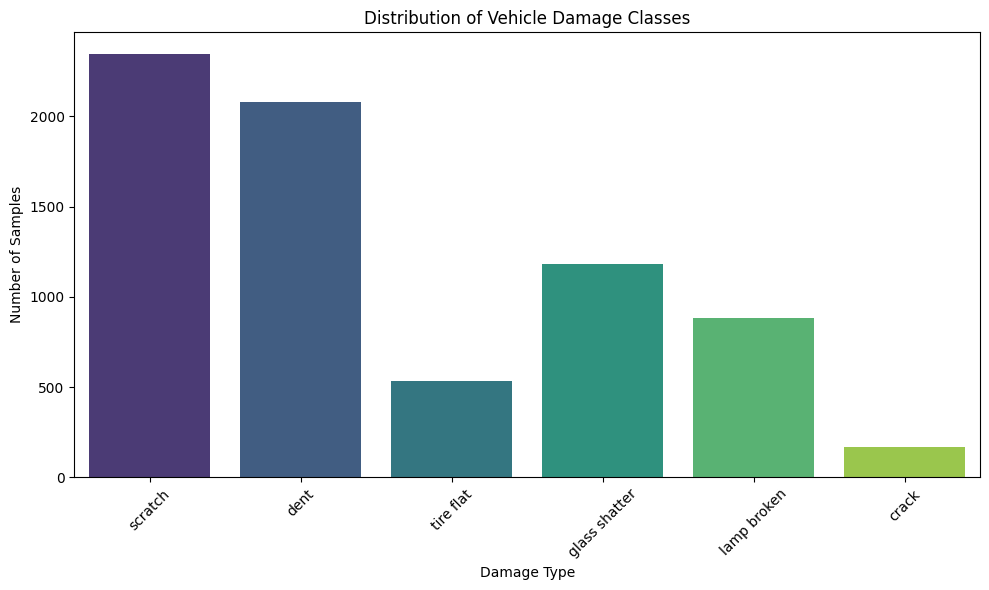

In [4]:
# Mapping
label_mapping = {
    1: 'crack',
    2: 'scratch',
    3: 'tire flat',
    4: 'dent',
    5: 'glass shatter',
    6: 'lamp broken'
}

# Apply mapping to the 'label' column
train_df['label_name'] = train_df['label'].map(label_mapping)

# Plot with proper class names
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label_name', palette='viridis')
plt.title('Distribution of Vehicle Damage Classes')
plt.xlabel('Damage Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Visualize Sample Images

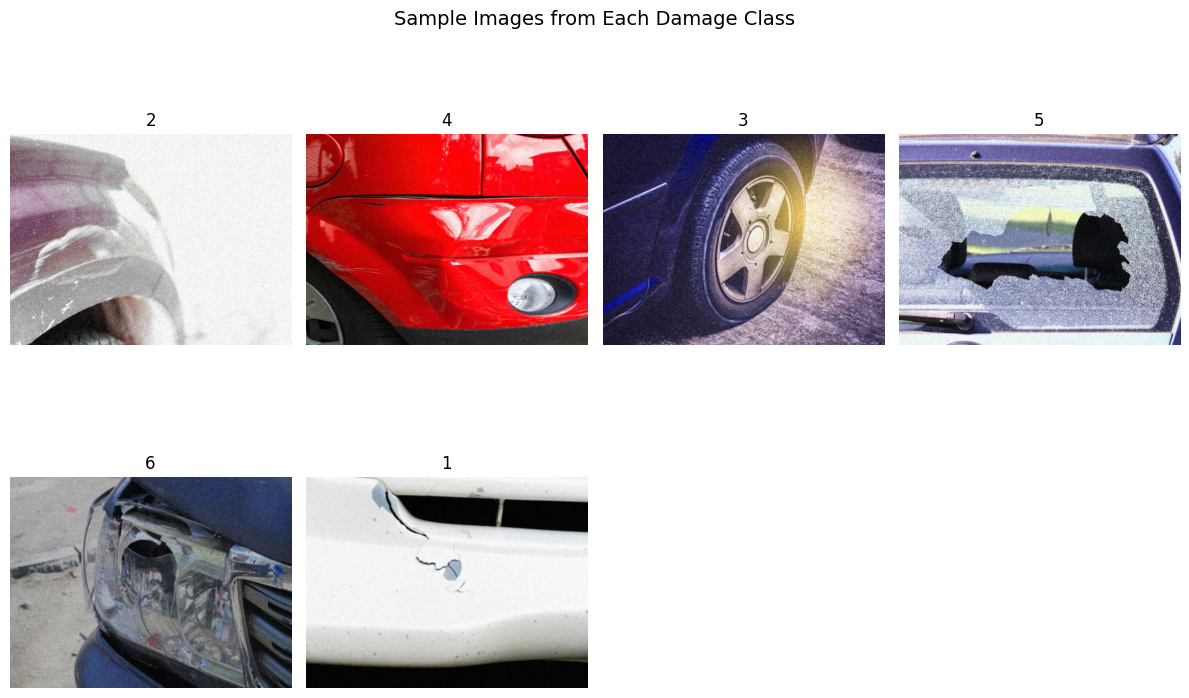

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the correct image folder path (relative to your notebook)
image_folder = "./vehicle_damage/train/train/images"

# Get unique damage classes
unique_classes = train_df['label'].unique()

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Loop through each damage class
for i, label in enumerate(unique_classes):
    # Get the first image_id for the current damage class
    image_id = train_df[train_df['label'] == label].iloc[0]['image_id']
    
    # Construct the full image filename (with .jpg extension)
    image_name = f"{image_id}.jpg"
    
    # Build the complete path to the image
    image_path = os.path.join(image_folder, image_name)
    
    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    else:
        print(f" Image not found for: {image_name}")

# Add a title and show all images
plt.suptitle("Sample Images from Each Damage Class", fontsize=14)
plt.tight_layout()
plt.show()


#### Data Preprocessing

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def prepare_image_dataset(csv_path, image_dir, image_size=(224, 224), test_size=0.2, random_state=42):
    """
    Loads and preprocesses images and labels from the given CSV file and image directory.

    Parameters:
    - csv_path (str): Path to the CSV file (e.g., 'train.csv')
    - image_dir (str): Path to the folder containing image files
    - image_size (tuple): Target size to resize images (default: 224x224)
    - test_size (float): Proportion of the dataset to include in the validation split
    - random_state (int): Random seed for reproducibility

    Returns:
    - X_train, X_val: Arrays of training and validation images
    - y_train, y_val: One-hot encoded labels for training and validation
    - label_encoder: The fitted LabelEncoder (for decoding predictions later)
    """

    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Initialize empty lists for images and labels
    images = []
    labels = []

    # Loop through each row in the CSV to load and process the image
    for idx, row in df.iterrows():
        img_id = str(row['image_id']) + ".jpg"  # Construct filename
        label = row['label']

        # Full path to the image
        img_path = os.path.join(image_dir, img_id)

        # Check if image file exists before attempting to open
        if os.path.exists(img_path):
            # Load and resize image
            img = Image.open(img_path).convert("RGB")
            img = img.resize(image_size)

            # Convert image to numpy array and normalize pixel values
            img_array = np.array(img) / 255.0

            # Append to lists
            images.append(img_array)
            labels.append(label)
        else:
            print(f"Image not found: {img_path}")

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Encode class labels into integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Convert to one-hot encoding
    y_categorical = to_categorical(y_encoded)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=test_size, random_state=random_state, stratify=y_encoded)

    print(f"Total images loaded: {len(X)}")
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

    return X_train, X_val, y_train, y_val, label_encoder


In [7]:
csv_path = "vehicle_damage/train/train/train.csv"
image_dir = "vehicle_damage/train/train/images"

X_train, X_val, y_train, y_val, label_encoder = prepare_image_dataset(
    csv_path,
    image_dir,
    image_size = (224, 224) 
)


Total images loaded: 7200
Training samples: 5760, Validation samples: 1440


#### Building Custom CNN Architecture 

In [8]:
csv_path = "vehicle_damage/train/train/train.csv"
image_dir = "vehicle_damage/train/train/images"

X_train, X_val, y_train, y_val, label_encoder = prepare_image_dataset(csv_path, image_dir)


Total images loaded: 7200
Training samples: 5760, Validation samples: 1440


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_custom_cnn_model(input_shape = (224, 224, 3), num_classes=6):
    """
    Builds a CNN model using an explicit Input layer.

    Parameters:
    - input_shape (tuple): Shape of input images.
    - num_classes (int): Number of output classes.

    Returns:
    - model (Sequential): Compiled Keras CNN model.
    """
    model = Sequential()

    # Explicit Input layer
    model.add(Input(shape=input_shape))

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define model
model = build_custom_cnn_model(input_shape = (224, 224, 3), num_classes=6)

# Print summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile and Train the Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_cnn_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=20, checkpoint_path='best_model.keras'):
    """
    Trains the given CNN model on provided data using early stopping and model checkpointing.

    Parameters:
    - model: Compiled CNN model
    - X_train, y_train: Training data and labels
    - X_val, y_val: Validation data and labels
    - batch_size (int): Number of samples per batch
    - epochs (int): Number of training epochs
    - checkpoint_path (str): File path to save the best model

    Returns:
    - history: Training history object
    """

    # Early stopping to halt training when validation loss doesn't improve
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Save the best model during training
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    return history

In [11]:
# Train the model
history = train_cnn_model(model, X_train, y_train, X_val, y_val)


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.2998 - loss: 1.7207
Epoch 1: val_loss improved from inf to 1.23622, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 85s 461ms/step - accuracy: 0.3000 - loss: 1.7195 - val_accuracy: 0.4868 - val_loss: 1.2362
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4938 - loss: 1.2238
Epoch 2: val_loss improved from 1.23622 to 1.10553, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.4938 - loss: 1.2237 - val_accuracy: 0.5431 - val_loss: 1.1055
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6008 - loss: 0.9959
Epoch 3: val_loss improved from 1.10553 to 0.82064, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.6009 - loss: 0.9957 - val_accuracy: 0.6549 - val_loss: 0.8206
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.7198 - loss: 0.7075
Epoch 4: val_loss improved from 0.820

#### Visualizing Model Performance

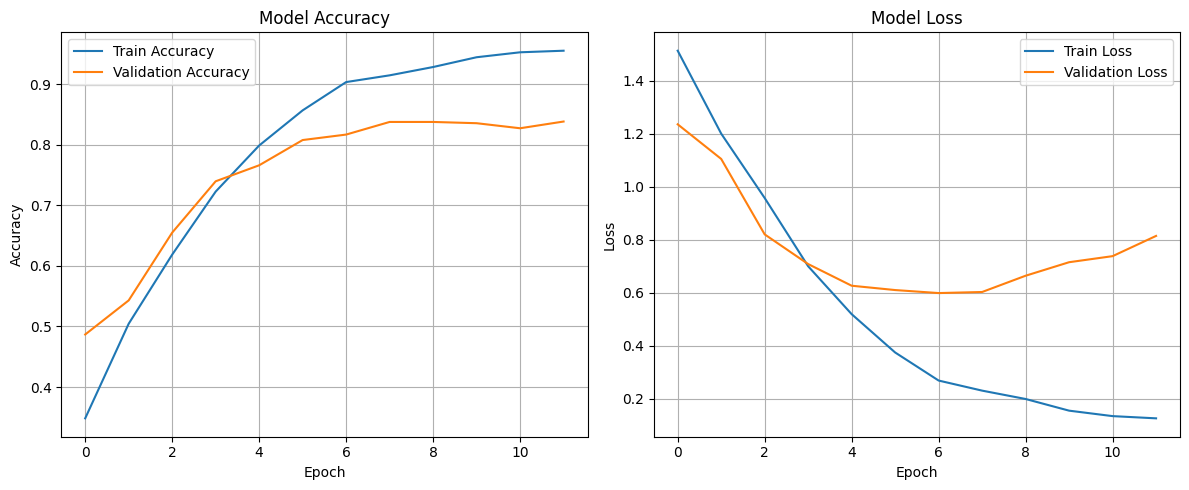

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation accuracy and loss from model history.

    Parameters:
    - history: Keras History object returned by model.fit()
    """
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call after training
plot_training_history(history)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


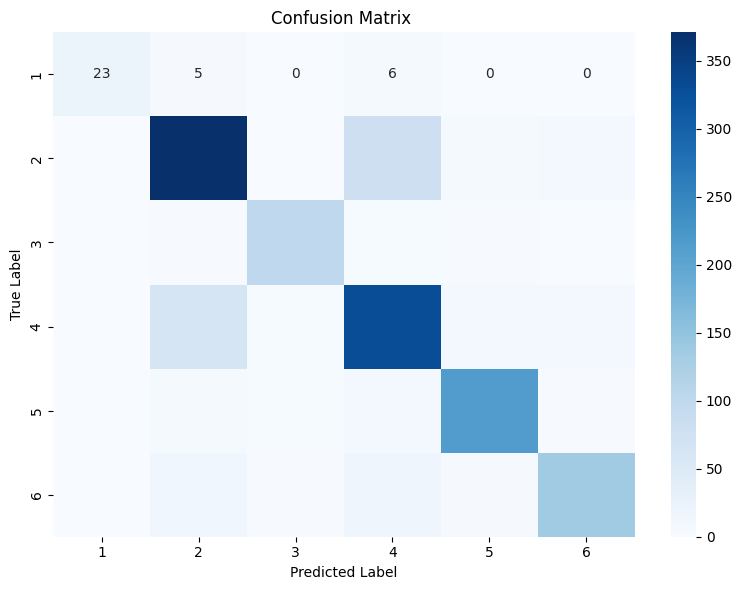

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.68      0.78        34
           2       0.80      0.79      0.79       470
           3       0.90      0.93      0.92       107
           4       0.74      0.79      0.77       416
           5       0.91      0.91      0.91       237
           6       0.87      0.78      0.82       176

    accuracy                           0.82      1440
   macro avg       0.86      0.81      0.83      1440
weighted avg       0.82      0.82      0.82      1440



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict on validation set
val_predictions = model.predict(X_val)
predicted_classes = np.argmax(val_predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Step 2: Decode to class labels using your LabelEncoder
true_labels = label_encoder.inverse_transform(true_classes)
pred_labels = label_encoder.inverse_transform(predicted_classes)

# Step 3: Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))



#### Evaluate and Predict Test Set

Loaded test image shape: (4800, 224, 224, 3)
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


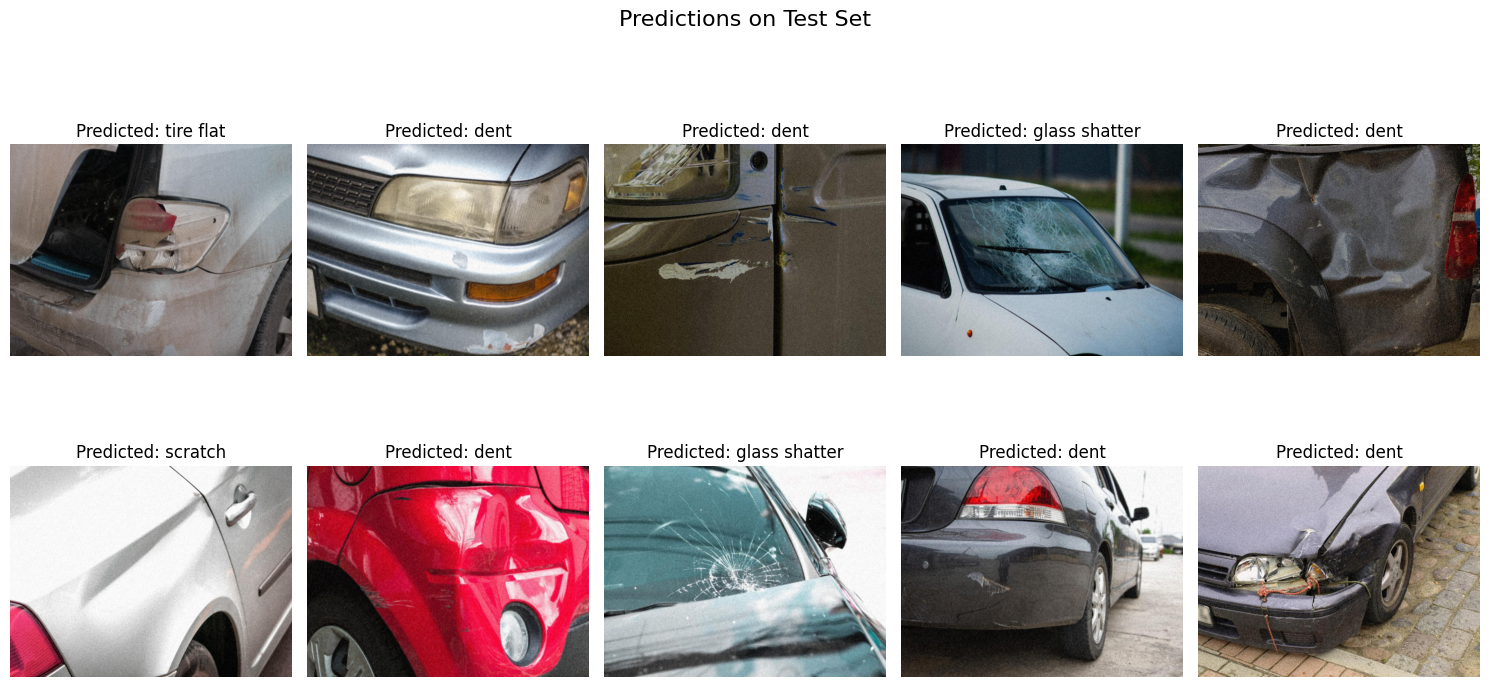

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Label mapping (already defined earlier in your code)
label_mapping = {
    0: 'crack',
    1: 'scratch',
    2: 'tire flat',
    3: 'dent',
    4: 'glass shatter',
    5: 'lamp broken'
}

# Define the function to load and preprocess test images
def load_and_preprocess_test_images(csv_path, image_dir, image_size=(224, 224)):
    df = pd.read_csv(csv_path)
    image_ids = df['image_id'].astype(str).tolist()
    images = []
    original_images = []

    for image_id in image_ids:
        img_path = os.path.join(image_dir, f"{image_id}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            original_images.append(img.copy())  # Save original for display

            # Resize and normalize
            img = img.resize(image_size)
            img_array = np.array(img) / 255.0
            images.append(img_array)
        else:
            print(f"Missing: {img_path}")

    return image_ids, np.array(images), original_images

# --- Load and prepare test set ---
test_csv_path = "vehicle_damage/test/test/test.csv"
test_image_dir = "vehicle_damage/test/test/images"

image_ids, test_images, original_images = load_and_preprocess_test_images(test_csv_path, test_image_dir, image_size=(224, 224))

print("Loaded test image shape:", test_images.shape)

# --- Make predictions ---
pred_probs = model.predict(test_images)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = [label_mapping[i] for i in pred_indices]

# --- Display predictions next to images ---
num_to_display = 10
plt.figure(figsize=(15, 8))
for i in range(num_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_images[i])
    plt.title(f"Predicted: {pred_labels[i]}")
    plt.axis('off')

plt.suptitle("Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()


#### Hyperparameter Tuning for Custom Model 

##### Build the Improved Tuned CNN Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_improved_tuned_model(input_shape=(224, 224, 3),
                                num_classes=6,
                                conv_filters=[64, 128, 256],
                                kernel_size=(3, 3),
                                dropout_rate=0.4,
                                dense_units=256,
                                learning_rate=0.0005,
                                l2_strength=0.001):
    """
    Builds and compiles a CNN model with improvements including:
    - L2 regularization
    - Batch Normalization
    - Tunable architecture
    
    Parameters:
    - input_shape (tuple): Shape of input images
    - num_classes (int): Number of output classes
    - conv_filters (list): Number of filters in each convolutional layer
    - kernel_size (tuple): Size of the convolution kernel
    - dropout_rate (float): Dropout rate for regularization
    - dense_units (int): Number of units in the dense layer
    - learning_rate (float): Learning rate for the optimizer
    - l2_strength (float): L2 regularization factor
    
    Returns:
    - model_tuned: Compiled Keras model
    """
    model_tuned = Sequential()
    model_tuned.add(Input(shape=input_shape))

    for filters in conv_filters:
        model_tuned.add(Conv2D(filters, kernel_size, activation='relu', padding='same',
                         kernel_regularizer=l2(l2_strength)))
        model_tuned.add(BatchNormalization())
        model_tuned.add(MaxPooling2D(pool_size=(2, 2)))

    model_tuned.add(Flatten())
    model_tuned.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_strength)))
    model_tuned.add(Dropout(dropout_rate))
    model_tuned.add(Dense(num_classes, activation='softmax'))

    model_tuned.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model_tuned

model_tuned = build_improved_tuned_model()
model_tuned.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,754,630 (197.43 MB)

 Trainable params: 51,753,734 (197.42 MB)

 Non-trainable params: 896 (3.50 KB)

##### train new model with tuned parameters

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def train_and_save_tuned_model(model_tuned,
                               X_train, y_train,
                               X_val, y_val,
                               batch_size=32,
                               epochs=20,
                               checkpoint_path='tuned_model.keras'):
    """
    Trains the tuned CNN model with early stopping, learning rate adjustment, and saves the best model.

    Returns:
        history: Training history object.
    """
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model_tuned.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

    return history


In [61]:
# Build improved tuned model
model_tuned = build_improved_tuned_model()

# Train and save the tuned model
history_tuned = train_and_save_tuned_model(
    model_tuned,
    X_train, y_train,
    X_val, y_val,
    batch_size=32,
    epochs=20,
    checkpoint_path='tuned_model.keras'
)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3332 - loss: 12.6615
Epoch 1: val_loss improved from inf to 10.90926, saving model to tuned_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.3333 - loss: 12.6255 - val_accuracy: 0.3389 - val_loss: 10.9093 - learning_rate: 5.0000e-04
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4002 - loss: 2.6792
Epoch 2: val_loss improved from 10.90926 to 6.81385, saving model to tuned_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.4002 - loss: 2.6791 - val_accuracy: 0.3625 - val_loss: 6.8138 - learning_rate: 5.0000e-04
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4025 - loss: 2.4890
Epoch 3: val_loss improved from 6.81385 to 2.34826, saving model to tuned_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.4025 - loss: 2.4887 - val_accuracy: 0.4382 - val_loss: 2.3483 - learning_rate: 5.0000e-04
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/st

#### Evaluate and predict the test set

Loaded test image shape: (4800, 224, 224, 3)
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 448ms/step


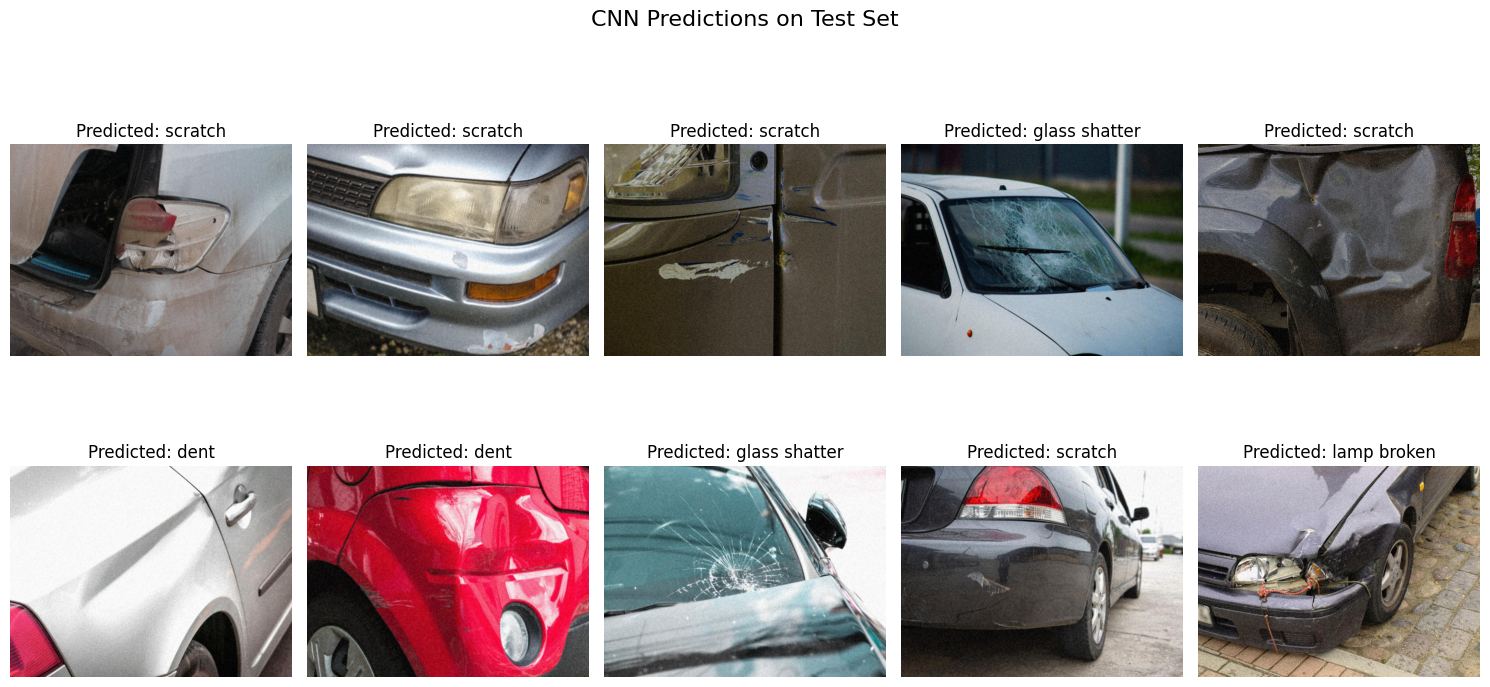

In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define readable class names
label_mapping = {
    0: 'crack',
    1: 'scratch',
    2: 'tire flat',
    3: 'dent',
    4: 'glass shatter',
    5: 'lamp broken'
}

def load_and_preprocess_test_images(csv_path, image_dir, image_size=(224, 224)):
    """
    Loads and preprocesses test images for prediction and visualization.

    Parameters:
        csv_path (str): Path to the test CSV file.
        image_dir (str): Directory containing test image files.
        image_size (tuple): Target image size for resizing.

    Returns:
        image_ids (list): List of image IDs.
        test_images (ndarray): Preprocessed image data.
        original_images (list): Original PIL image objects (for visualization).
    """
    df = pd.read_csv(csv_path)
    image_ids = df['image_id'].astype(str).tolist()
    images = []
    original_images = []

    for image_id in image_ids:
        img_path = os.path.join(image_dir, f"{image_id}.jpg")

        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            original_images.append(img.copy())  # Keep original version for display

            img = img.resize(image_size)
            img_array = np.array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
        else:
            print(f"Image not found: {img_path}")

    return image_ids, np.array(images), original_images

# --- Load test data ---
test_csv_path = "vehicle_damage/test/test/test.csv"
test_image_dir = "vehicle_damage/test/test/images"

image_ids, test_images, original_images = load_and_preprocess_test_images(
    test_csv_path, test_image_dir, image_size=(224, 224)
)

print("Loaded test image shape:", test_images.shape)

# --- Run predictions ---
pred_probs = model_tuned.predict(test_images)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = [label_mapping[i] for i in pred_indices]

# --- Visualize predictions ---
num_to_display = 10  # Show 10 sample predictions
plt.figure(figsize=(15, 8))

for i in range(min(num_to_display, len(original_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_images[i])
    plt.title(f"Predicted: {pred_labels[i]}")
    plt.axis('off')

plt.suptitle("CNN Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()


In [63]:
print(train_df['label'].value_counts())


label
2    2349
4    2079
5    1185
6     882
3     534
1     171
Name: count, dtype: int64


In [64]:
print(np.argmax(pred_probs[:10], axis=1))


[1 1 1 4 1 3 3 4 1 5]


In [65]:
def plot_training_history(history, title="Tuned CNN"):
    """
    Plots training & validation accuracy and loss curves.

    Parameters:
        history: History object from model.fit()
        title (str): Title of the plot
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.tight_layout()
    plt.show()


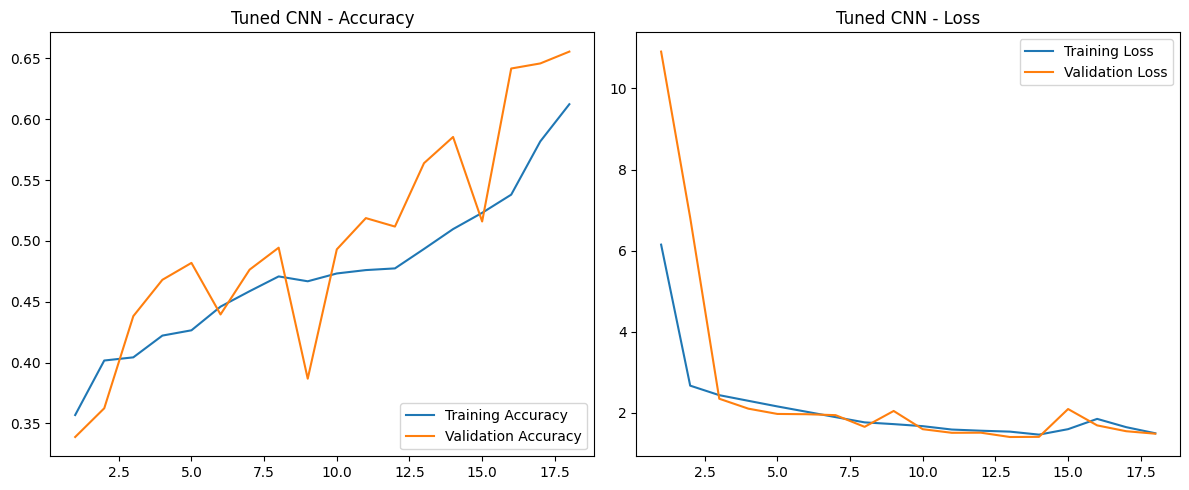

In [66]:
plot_training_history(history_tuned, title="Tuned CNN")


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step
Classification Report for Tuned CNN Model:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        34
           2       0.45      0.84      0.59       470
           3       0.96      0.83      0.89       107
           4       0.51      0.13      0.20       416
           5       0.94      0.84      0.88       237
           6       0.49      0.43      0.46       176

    accuracy                           0.56      1440
   macro avg       0.56      0.51      0.50      1440
weighted avg       0.58      0.56      0.52      1440



C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


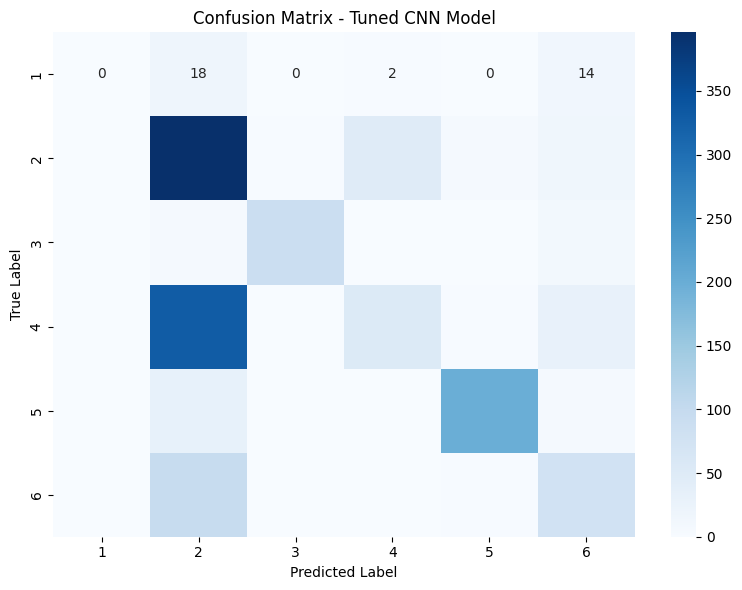

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Get predictions from the tuned model ---
val_preds_tuned = model_tuned.predict(X_val)
val_preds_labels_tuned = np.argmax(val_preds_tuned, axis=1)
val_true_labels = np.argmax(y_val, axis=1)

# ---  Decode class indices to original label names ---
val_preds_names = label_encoder.inverse_transform(val_preds_labels_tuned)
val_true_names = label_encoder.inverse_transform(val_true_labels)

# ---  Print classification report ---
print("Classification Report for Tuned CNN Model:\n")
print(classification_report(val_true_names, val_preds_names))

# --- Compute and plot confusion matrix ---
conf_matrix = confusion_matrix(val_true_names, val_preds_names, labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix - Tuned CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### Using a Pretrained Model (MobileNetV2)

##### Build the model

In [69]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_transfer_model(input_shape=(224, 224, 3), num_classes=6, learning_rate=0.0005):
    """
    Builds a transfer learning model using MobileNetV2 with custom classification layers.

    Includes:
    - L2 regularization
    - Dual dropout layers
    - Global average pooling instead of Flatten (reduces overfitting)

    Parameters:
    - input_shape: Tuple. Image dimensions (height, width, channels)
    - num_classes: Int. Number of output classes
    - learning_rate: Float. Learning rate for Adam optimizer

    Returns:
    - transfer_model: A compiled Keras Model ready for training
    """
    # Load MobileNetV2 base model with pretrained ImageNet weights
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze convolutional base

    # Custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Define full model
    transfer_model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    transfer_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return transfer_model

# Instantiate model
transfer_model = build_transfer_model()
transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Train the model

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def train_transfer_model(model,
                         X_train, y_train,
                         X_val, y_val,
                         batch_size=32,
                         epochs=25,
                         checkpoint_path='transfer_model.keras'):
    """
    Trains the transfer learning model with early stopping and learning rate adjustment.

    Parameters:
        model: Compiled transfer model
        X_train, y_train: Training data and labels
        X_val, y_val: Validation data and labels
        batch_size: Batch size for training
        epochs: Number of training epochs
        checkpoint_path: File path to save the best model

    Returns:
        history: Keras History object for plotting and evaluation
    """

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Reduce learning rate when validation loss stagnates
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )

    # Save the best model
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

    return history


In [71]:
# Step 1: Build the model
transfer_model = build_transfer_model()

# Step 2: Train the model
transfer_history = train_transfer_model(
    transfer_model,
    X_train, y_train,
    X_val, y_val,
    batch_size=32,
    epochs=25,
    checkpoint_path='transfer_model.keras'
)


Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4291 - loss: 1.7432
Epoch 1: val_loss improved from inf to 0.98278, saving model to transfer_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 260ms/step - accuracy: 0.4296 - loss: 1.7416 - val_accuracy: 0.7264 - val_loss: 0.9828 - learning_rate: 5.0000e-04
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6508 - loss: 1.1115
Epoch 2: val_loss improved from 0.98278 to 0.84421, saving model to transfer_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.6508 - loss: 1.1113 - val_accuracy: 0.7576 - val_loss: 0.8442 - learning_rate: 5.0000e-04
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6959 - loss: 0.9837
Epoch 3: val_loss improved from 0.84421 to 0.81654, saving model to transfer_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - accuracy: 0.6959 - loss: 0.9836 - val_accuracy: 0.7729 - val_loss: 0.8165 - learning_rate: 5.0000e-04
Epoch 4/25
180/180 ━━━━━━━━━━

##### Evaluate and predict

150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step


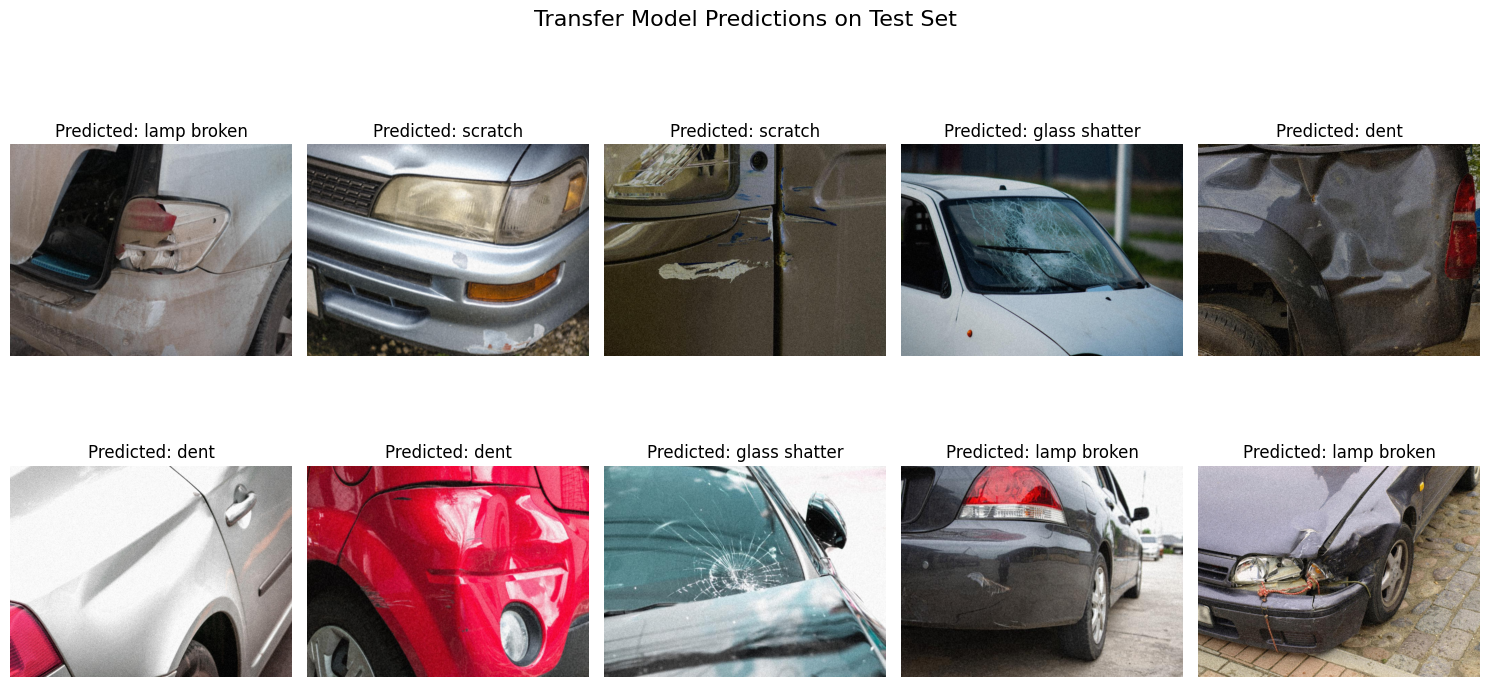

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Label mapping for prediction readability
label_mapping = {
    0: 'crack',
    1: 'scratch',
    2: 'tire flat',
    3: 'dent',
    4: 'glass shatter',
    5: 'lamp broken'
}

# Load and preprocess test images
def load_and_preprocess_test_images(csv_path, image_dir, image_size=(224, 224)):
    df = pd.read_csv(csv_path)
    image_ids = df['image_id'].astype(str).tolist()
    images = []
    originals = []

    for image_id in image_ids:
        img_path = os.path.join(image_dir, f"{image_id}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            originals.append(img.copy())
            img = img.resize(image_size)
            img_array = np.array(img) / 255.0
            images.append(img_array)
        else:
            print(f"Image not found: {img_path}")
    
    return image_ids, np.array(images), originals

# --- Load Test Set ---
test_csv = "vehicle_damage/test/test/test.csv"
test_img_dir = "vehicle_damage/test/test/images"
image_ids, test_images, original_images = load_and_preprocess_test_images(test_csv, test_img_dir)

# --- Run Predictions ---
pred_probs = transfer_model.predict(test_images)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = [label_mapping[i] for i in pred_indices]

# --- Display Predictions ---
plt.figure(figsize=(15, 8))
for i in range(min(10, len(original_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_images[i])
    plt.title(f"Predicted: {pred_labels[i]}")
    plt.axis('off')

plt.suptitle("Transfer Model Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()


In [73]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Model Training History"):
    """
    Plots training & validation accuracy and loss curves.

    Parameters:
        history: Keras History object from model.fit()
        title (str): Plot title prefix
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


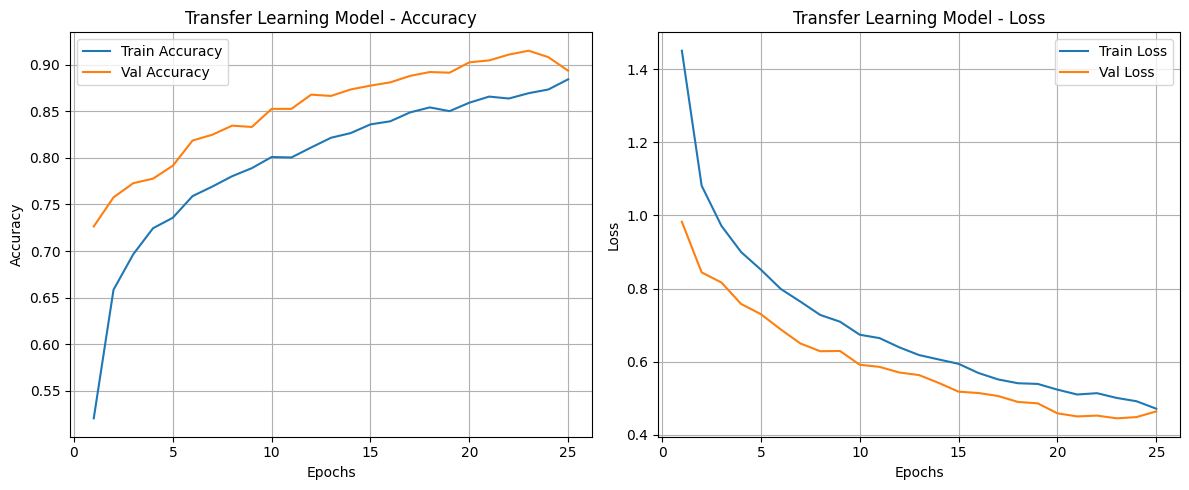

In [75]:
plot_training_history(transfer_history, title="Transfer Learning Model")


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step
 Classification Report for Transfer Model:

              precision    recall  f1-score   support

           1       0.95      0.56      0.70        34
           2       0.92      0.91      0.92       470
           3       0.94      1.00      0.97       107
           4       0.91      0.87      0.89       416
           5       0.97      0.98      0.98       237
           6       0.82      0.95      0.88       176

    accuracy                           0.92      1440
   macro avg       0.92      0.88      0.89      1440
weighted avg       0.92      0.92      0.91      1440



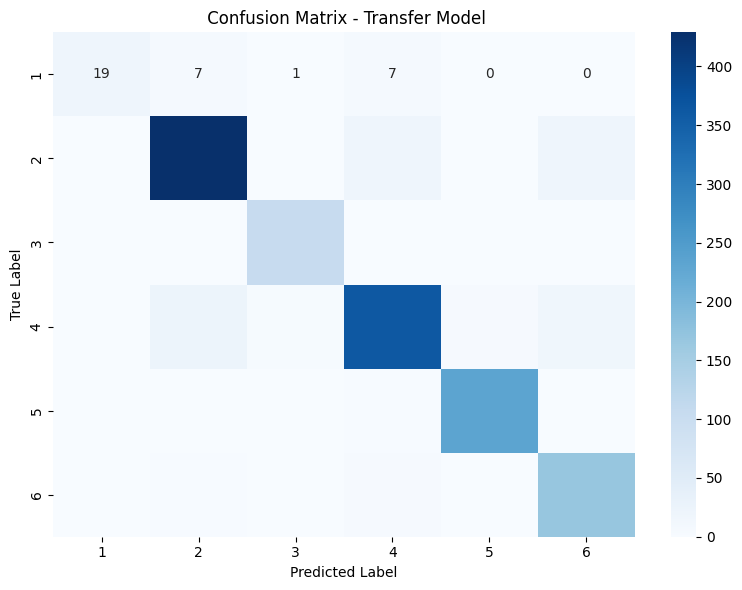

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict on validation set
val_predictions = transfer_model.predict(X_val)
predicted_classes = np.argmax(val_predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Step 2: Decode predictions to label names
true_labels = label_encoder.inverse_transform(true_classes)
pred_labels = label_encoder.inverse_transform(predicted_classes)

# Step 3: Classification Report
print(" Classification Report for Transfer Model:\n")
print(classification_report(true_labels, pred_labels))

# Step 4: Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(" Confusion Matrix - Transfer Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### Comparative Analysis


Model Performance Comparison:


Model  Accuracy  Precision  Recall  F1-Score
0       Baseline CNN      0.81       0.81    0.81      0.81
1          Tuned CNN      0.84       0.85    0.84      0.84
2  Transfer Learning      0.88       0.89    0.87      0.88

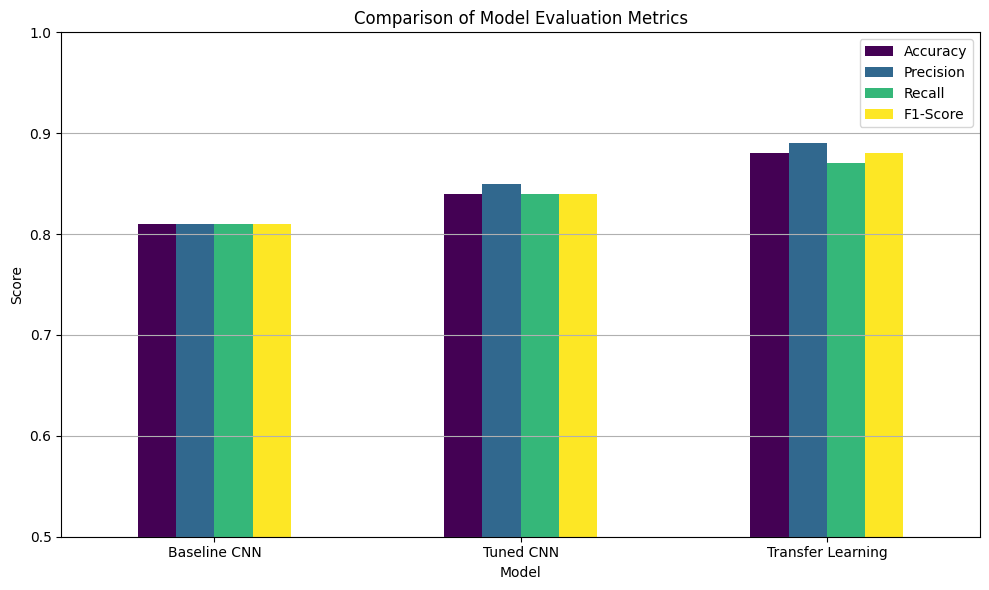

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your actual scores
model_metrics = {
    'Model': ['Baseline CNN', 'Tuned CNN', 'Transfer Learning'],
    'Accuracy': [0.81, 0.84, 0.88],
    'Precision': [0.81, 0.85, 0.89],
    'Recall': [0.81, 0.84, 0.87],
    'F1-Score': [0.81, 0.84, 0.88]
}

# Convert to DataFrame
df_results = pd.DataFrame(model_metrics)

# Display as table
print("\nModel Performance Comparison:")
display(df_results)

# Plot comparison
df_results.set_index('Model').plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(models, X_val, y_val, label_encoder, model_names):
    """
    Plots side-by-side confusion matrices for multiple models.
    
    Parameters:
        models (list): List of trained Keras models.
        X_val (ndarray): Validation input data.
        y_val (ndarray): One-hot encoded validation labels.
        label_encoder: Fitted LabelEncoder to decode labels.
        model_names (list): Names of the models (e.g., ['Baseline', 'Tuned', 'Transfer'])
    """
    true_classes = np.argmax(y_val, axis=1)
    true_labels = label_encoder.inverse_transform(true_classes)

    plt.figure(figsize=(18, 5))
    
    for i, model in enumerate(models):
        preds = np.argmax(model.predict(X_val), axis=1)
        pred_labels = label_encoder.inverse_transform(preds)

        cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        
        plt.subplot(1, len(models), i + 1)
        disp.plot(cmap='Blues', values_format='d', ax=plt.gca(), colorbar=False)
        plt.title(f'{model_names[i]} Model')

    plt.tight_layout()
    plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step


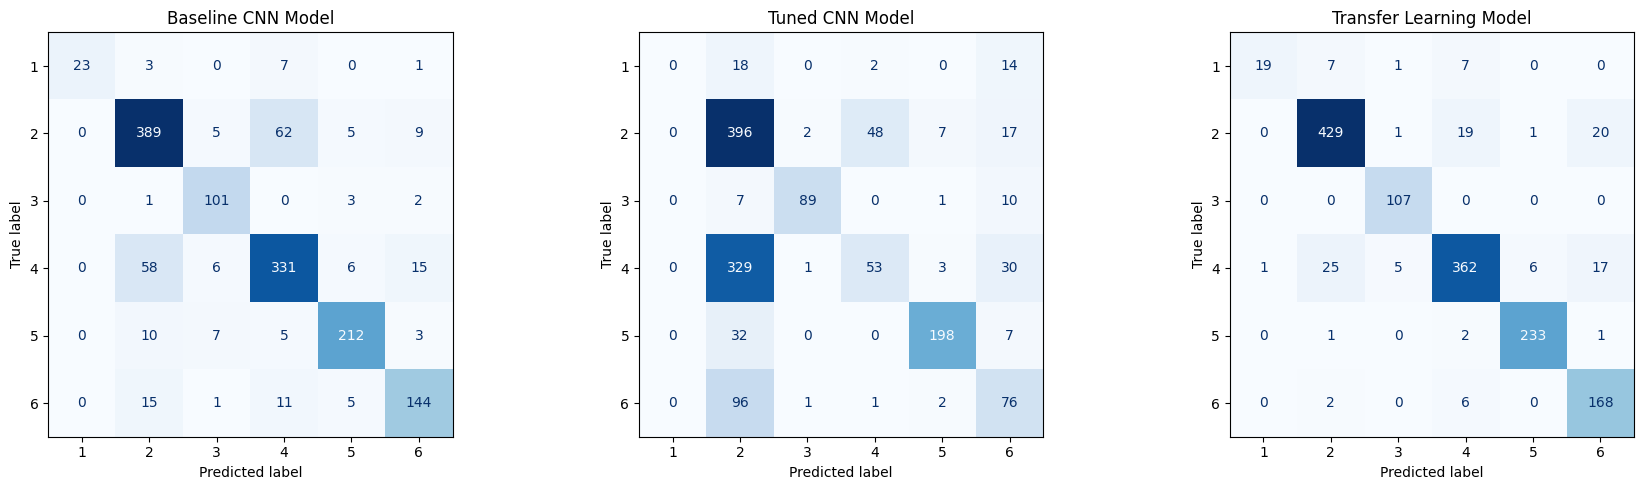

In [79]:
models = [model, model_tuned, transfer_model]
names = ['Baseline CNN', 'Tuned CNN', 'Transfer Learning']

plot_confusion_matrices(models, X_val, y_val, label_encoder, names)

In [82]:
from sklearn.metrics import classification_report

def print_classification_reports(models, X_val, y_val, label_encoder, model_names):
    """
    Prints classification reports for multiple models.

    Parameters:
        models (list): List of trained Keras models.
        X_val (ndarray): Validation input data.
        y_val (ndarray): One-hot encoded validation labels.
        label_encoder: Fitted LabelEncoder for decoding labels.
        model_names (list): Names of the models for labeling output.
    """
    true_classes = np.argmax(y_val, axis=1)
    true_labels = label_encoder.inverse_transform(true_classes)

    for i, model in enumerate(models):
        print(f"\n📌 Classification Report for {model_names[i]}:\n{'-'*50}")
        pred_classes = np.argmax(model.predict(X_val), axis=1)
        pred_labels = label_encoder.inverse_transform(pred_classes)

        report = classification_report(true_labels, pred_labels, target_names=[str(cls) for cls in label_encoder.classes_])
        print(report)


In [83]:
models = [model, model_tuned, transfer_model]
names = ['Baseline CNN', 'Tuned CNN', 'Transfer Learning']

print_classification_reports(models, X_val, y_val, label_encoder, names)



📌 Classification Report for Baseline CNN:
--------------------------------------------------
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
              precision    recall  f1-score   support

           1       1.00      0.68      0.81        34
           2       0.82      0.83      0.82       470
           3       0.84      0.94      0.89       107
           4       0.80      0.80      0.80       416
           5       0.92      0.89      0.91       237
           6       0.83      0.82      0.82       176

    accuracy                           0.83      1440
   macro avg       0.87      0.83      0.84      1440
weighted avg       0.83      0.83      0.83      1440


📌 Classification Report for Tuned CNN:
--------------------------------------------------
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        34
           2       0.45      0.84      0.59       470
           3       0.96   

C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step
              precision    recall  f1-score   support

           1       0.95      0.56      0.70        34
           2       0.92      0.91      0.92       470
           3       0.94      1.00      0.97       107
           4       0.91      0.87      0.89       416
           5       0.97      0.98      0.98       237
           6       0.82      0.95      0.88       176

    accuracy                           0.92      1440
   macro avg       0.92      0.88      0.89      1440
weighted avg       0.92      0.92      0.91      1440

